In [1]:
import pandas as pd
import geopandas as gpd
import rasterio as rio
import xarray as xr
from xrspatial import proximity
from rasterio.plot import show
from rasterio import features
from rasterio.crs import CRS
import numpy as np

In [2]:
cper_2017_f = 'C:/SPK_local/data/vectors/Pasture_Boundaries/Shapefiles/cper_pastures_2017_clip.shp'
cper_tanks_f = 'C:/SPK_local/data/vectors/CPER_features/Stock_Tank_V1.shp'
ras_templ_f = 'C:/SPK_local/data/rasters/HLS/HLS_quality/CPER_CP_2017.tif'

In [3]:
def shp2mask(shp, xr_object, fill=0, **kwargs):
    raster = features.rasterize(shp, fill=fill, transform=xr_object.transform,
                                out_shape=xr_object.shape[1:], dtype='int16', **kwargs)
    return xr.DataArray(raster,
                        coords=(xr_object.coords['y'].values, xr_object.coords['x']),
                        dims=('y', 'x'))

def multi2single(gpdf):
    gpdf_singlepoly = gpdf[gpdf.geometry.type == 'Polygon']
    gpdf_multipoly = gpdf[gpdf.geometry.type == 'MultiPolygon']

    for i, row in gpdf_multipoly.iterrows():
        Series_geometries = pd.Series(row.geometry)
        df = pd.concat([gpd.GeoDataFrame(row, crs=gpdf_multipoly.crs).T]*len(Series_geometries), ignore_index=True)
        df['geometry']  = Series_geometries
        gpdf_singlepoly = pd.concat([gpdf_singlepoly, df])

    gpdf_singlepoly.reset_index(inplace=True, drop=True)
    return gpdf_singlepoly

In [4]:
ras_templ = xr.open_rasterio(ras_templ_f)

In [5]:
cper = gpd.read_file(cper_2017_f)
cper['PAST_NEW'] = cper['Past_Name_']
cper.loc[cper['PAST_NEW'] == '21SW', 'PAST_NEW'] = '21S'
cper['geometry'] = cper.buffer(10)
cper = cper.dissolve(by='PAST_NEW')
cper['area_ha'] = cper['geometry'].area / 10 ** 4
cper_bndry_mask = shp2mask(shp=cper.exterior, xr_object=ras_templ)
cper_dist_fence = proximity(cper_bndry_mask).astype('int')

In [6]:
cper_tanks = gpd.read_file(cper_tanks_f)
cper_tank_mask = shp2mask(shp=cper_tanks['geometry'], xr_object=ras_templ)
cper_dist_tank = proximity(cper_tank_mask).astype('int')

In [7]:
cper_dist_fence

<xarray.DataArray (y: 323, x: 323)>
array([[2903, 2887, 2871, ...,    0,   30,   60],
       [2878, 2862, 2846, ...,    0,   30,   60],
       [2853, 2837, 2820, ...,    0,   30,   60],
       ...,
       [1785, 1758, 1730, ...,  360,  390,  420],
       [1797, 1771, 1744, ...,  360,  390,  420],
       [1811, 1784, 1757, ...,  360,  390,  420]])
Coordinates:
  * y        (y) float64 4.524e+06 4.524e+06 4.524e+06 ... 4.515e+06 4.515e+06
  * x        (x) float64 5.176e+05 5.176e+05 5.177e+05 ... 5.272e+05 5.273e+05

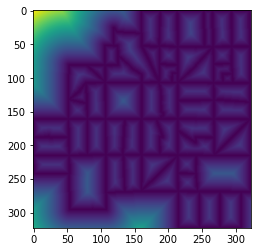

<AxesSubplot:>

In [8]:
show(cper_dist_fence)

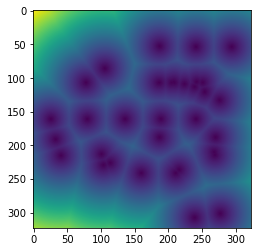

<AxesSubplot:>

In [9]:
show(cper_dist_tank)

In [14]:
out_profile = {'driver': 'GTiff',
                       'dtype': 'int16',
                       'nodata': -999,
                       'width': len(ras_templ.x),
                       'height': len(ras_templ.y),
                       'count': 1,
                       'crs': CRS.from_dict(init='epsg:32613'),
                       'transform': rio.Affine(30.0, 0.0, np.min(ras_templ.x - 15.0).data,
                                               0.0, -30.0, np.max(ras_templ.y + 15.0).data),
                       'tiled': False}
with rio.open('C:/SPK_local/data/rasters/Masks/CPER_dist_to_fence_2017.tif',
              'w', **out_profile) as dst:
    dst.write(cper_dist_fence.data[np.newaxis, :, :])
    
with rio.open('C:/SPK_local/data/rasters/Masks/CPER_dist_to_tank_2017.tif',
              'w', **out_profile) as dst:
    dst.write(cper_dist_tank.data[np.newaxis, :, :])

In [15]:
from shapely.geometry import mapping, MultiPoint, Point, LineString, MultiPolygon, Polygon


def calc_vangle(a_list, b_list, c_list):
    out_series = []
    for a, b, c in zip(a_list, b_list, c_list):
        ba = a - b
        bc = c - b

        cosine_angle = np.dot(ba, bc) / (np.linalg.norm(ba) * np.linalg.norm(bc))
        angle = np.arccos(cosine_angle)
        out_series.append(np.degrees(angle))
    return out_series


def check_inside(poly_coords):
    polygon = Polygon(poly_coords)
    bool_list = []
    for i, pt in enumerate(poly_coords[:-1]):
        line = gpd.GeoSeries(LineString([np.roll(np.array(poly_coords)[:-1], shift=-1, axis=0)[i],
                                         np.roll(np.array(poly_coords)[:-1], shift=1, axis=0)[i]]))
        checkpoint = line.geometry.interpolate(line.length/2)
        bool_list.append(polygon.contains(checkpoint[0]))
    return bool_list

In [16]:
corners_xr_list = []
gdf_corners = gpd.GeoDataFrame()
for idx, p in enumerate(cper.exterior):
    if p is None:
        continue
    else:
        g = p.simplify(tolerance=30)
        x, y = g.coords.xy
        ext_coords = list(zip(x, y))
        #ext_coords = mapping(g)["coordinates"][0]
        angles = calc_vangle(np.roll(np.array(ext_coords)[:-1], shift=-1, axis=0), 
                np.roll(np.array(ext_coords[:-1]), shift=0, axis=0), 
               np.roll(np.array(ext_coords)[:-1], shift=1, axis=0))
        insides = check_inside(ext_coords)
        corners_tmp = MultiPoint(np.array(ext_coords[:-1])[list(np.logical_and([i < 150 for i in angles], insides))].tolist())
        gdf_tmp = gpd.GeoDataFrame(corners_tmp)
        gdf_tmp = gdf_tmp.assign(Pasture=cper.index[idx])
        gdf_tmp = gdf_tmp.rename(columns={0: 'geometry'})
        gdf_corners = gdf_corners.append(gdf_tmp)
        past_mask = shp2mask(shp=MultiPolygon([Polygon(p)]), xr_object=ras_templ)
        past_corners_mask = shp2mask(shp=corners_tmp, xr_object=ras_templ)
        past_dist_corners = proximity(past_corners_mask).astype('int')
        past_dist_corners = past_dist_corners.where(past_mask==1)
        past_dist_corners.name = idx
        #past_dist_corners.assign_coords(Pasture=)
        corners_xr_list.append(past_dist_corners)

In [18]:
gdf_corners = gdf_corners.set_crs(32613)
gdf_corners.to_file('C:/SPK_local/data/vectors/CPER_features/CPER_pasture_corners.shp')

In [89]:
cper[cper.index=='24W'].exterior[0].simplify(50).coords.xy

(array('d', [523229.31000531063, 523228.57081546314, 522418.19786513364, 522414.39075601136, 523083.05932496773, 523354.35859843495, 523229.31000531063]),
 array('d', [4518741.980203006, 4517958.397520008, 4517967.836072366, 4519554.215207761, 4519556.205215975, 4518750.475579756, 4518741.980203006]))

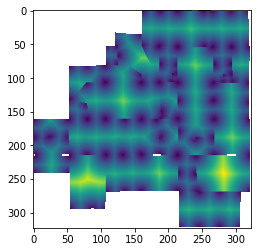

<AxesSubplot:>

In [17]:
cper_dist_corners = xr.concat(corners_xr_list, 'index').min('index')
show(cper_dist_corners)

In [27]:
out_profile = {'driver': 'GTiff',
                       'dtype': 'int16',
                       'nodata': -999,
                       'width': len(ras_templ.x),
                       'height': len(ras_templ.y),
                       'count': 1,
                       'crs': CRS.from_dict(init='epsg:32613'),
                       'transform': rio.Affine(30.0, 0.0, np.min(ras_templ.x - 15.0).data,
                                               0.0, -30.0, np.max(ras_templ.y + 15.0).data),
                       'tiled': False}
with rio.open('C:/SPK_local/data/rasters/Masks/CPER_dist_to_corners_2017.tif',
              'w', **out_profile) as dst:
    dst.write(cper_dist_corners.data[np.newaxis, :, :])

<AxesSubplot:>

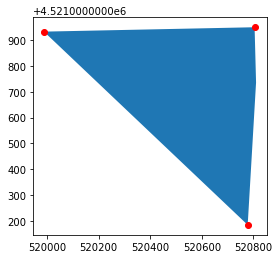

In [190]:
angles = calc_vangle(np.roll(np.array(ext_coords)[:-1], shift=-1, axis=0), 
            np.roll(np.array(ext_coords[:-1]), shift=0, axis=0), 
           np.roll(np.array(ext_coords)[:-1], shift=1, axis=0))
insides = check_inside(ext_coords)
corners = MultiPoint(np.array(ext_coords[:-1])[list(np.logical_and([i < 150 for i in angles], insides))].tolist())

polygon = Polygon(ext_coords)
ax = gpd.GeoSeries(polygon).plot()
gpd.GeoSeries(corners).plot(ax=ax, c='red')

In [176]:
angles

[135.3855082312454,
 44.92655521619251,
 130.59459059917614,
 165.04174105514355,
 53.619024602582655,
 91.62176149401203]

In [177]:
insides

[True, True, False, True, False, True]

True

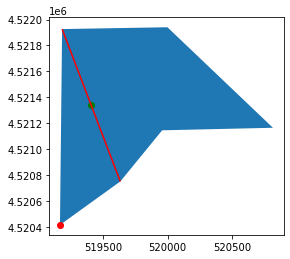

In [183]:
from shapely.geometry import Point, LineString
polygon = Polygon(ext_coords)
ax = gpd.GeoSeries(polygon).plot()
gpd.GeoSeries(Point(tuple(np.array(ext_coords)[4]))).plot(ax=ax, c='red')
gpd.GeoSeries(LineString([np.array(ext_coords)[3], np.array(ext_coords)[5]])).plot(ax=ax, color='red')
point = gpd.GeoSeries(Point(tuple(np.array(ext_coords)[4])))
line = gpd.GeoSeries(LineString([np.array(ext_coords)[3], np.array(ext_coords)[5]]))
checkpoint = line.geometry.interpolate(line.length/2)
checkpoint.plot(ax=ax, c='green')
polygon.contains(checkpoint[0])

In [181]:
line.length

0    1259.388097
dtype: float64

In [72]:
np.roll(np.array(ext_coords), shift=1, axis=0)

array([[ 519997.95400464, 4521940.56842816],
       [ 519997.95400464, 4521940.56842816],
       [ 520812.46793184, 4521164.48178273],
       [ 519957.27255292, 4521144.91797919],
       [ 519634.1065807 , 4520749.86265254],
       [ 519168.41104976, 4520414.51550625],
       [ 519184.85975335, 4521926.39810283]])